# The Mouse Cortical Model + Advanced Features

The goal of this chapter is an introduction of how with more realistic models using some of the more advanced features of the BMTK. 

These features can be useful whether you are building a more realistic network model from scratch or intend to carry out simulations of an existing model like the Allen Institute models of the Mouse Primary Visual Cortex (see [here](https://portal.brain-map.org/explore/models/mv1-all-layers)). 

In modeling practice, it is often the case that one needs to use such an existing model with some modifications. Many possibilities to do so are offered by the modular SONATA format, where one can modify the config files and/or the data files containing components of the model, such as nodes, edges, cell and synapse models, etc. 

In addition, BMTK offers ways to change certain aspects of the models at runtime. This can sometimes be preferable relative to replacing static structure of the model, for example, in cases when one may need to sample many possible conditions in separate simulations – rebuilding components of the model for every simulation may be cumbersome in such a situation. Some approaches for runtime modifications are illustrated below. 

Throughout this chapter, we will use a reduced version of the network model of the Layer 4 (L4) from the mouse V1 (full version can be found [here](https://portal.brain-map.org/explore/models/mv1-all-layers)). The complete V1 model (230,000 neurons) or just the model of V1 L4 (45,000 neurons) are too large for quick training simulations. Therefore, we are using here a smaller (2,300 neurons) network model with less diversity and complexity in the node and edge types; however, all the operations illustrated in this chapter can be successfully applied to much larger and more complex networks.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import h5py
import glob
import nest

from bmtk.analyzer.spike_trains import plot_rates_boxplot, plot_rates, plot_raster
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains


pd.set_option('display.max_rows', None)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Mar  1 2022 09:35:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## [6A. Building the Model](6A.%20Building%20the%20L4%20Network.ipynb)

We have already built a reduced model of the Mouse Primary Visual Cortex with only Layer 4 cells which has been saved in the **network/** directory. The rules used to build the network are not necessary for the rest of the chapter, and can be time consuming to rebuild from scratch. But should one be interested in how the network was built more details can be found [here](6A.%20Building%20the%20L4%20Network.ipynb).

The core of the network is internal "L4" (Layer 4) cells saved in the l4_nodes.h5 and l4_node_types.csv files. To get a sense of the make-up of the network let's use ```bmtk.utils.sonata``` functionality to load the nodes into a Panda's dataframe:

In [2]:
net = sonata.File(
    data_files='network/l4_nodes.h5',
    data_type_files='network/l4_node_types.csv'
)
l4_nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
l4_nodes_df['node_count'] = 1
l4_nodes_df[['layer', 'ei', 'model_name',  'dynamics_params', 'model_template', 'model_type', 'node_count']].groupby(['layer', 'ei', 'model_name', 'model_template', 'model_type', 'dynamics_params']).agg('count')

node_count
layer ei model_name       model_template        model_type   dynamics_params                               
VisL4 e  Rorb_314642645   nest:glif_lif_asc_psc point_neuron 314642645_glif_lif_asc_config.json         594
         Scnn1a_517982558 nest:glif_lif_asc_psc point_neuron 517982558_glif_lif_asc_config.json         686
         other_483018019  nest:glif_lif_asc_psc point_neuron 483018019_glif_lif_asc_config.json         732
      i  Htr3a_474626527  nest:glif_lif_asc_psc point_neuron 474626527_glif_lif_asc_config.json          61
         Pvalb_478958894  nest:glif_lif_asc_psc point_neuron 478958894_glif_lif_asc_config.json         223
         Sst_501282204    nest:glif_lif_asc_psc point_neuron 501282204_glif_lif_asc_config.json         119

Let us also look at the overall makeup of the recurrent (L4 --> L4) connections

In [3]:
l4_edges_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ').sort_values(['dynamics_params', 'target_query'])
with h5py.File('network/l4_l4_edges.h5', 'r') as h5:
    edge_ids, edge_counts = np.unique(h5['/edges/l4_to_l4/edge_type_id'][()], return_counts=True)
    edge_counts_df = pd.DataFrame({'edge_type_id': edge_ids, 'counts': edge_counts})
    l4_edges_df = l4_edges_df.merge(edge_counts_df, how='left', on='edge_type_id')

l4_edges_df.set_index(['edge_type_id', 'target_query', 'source_query', 'dynamics_params'])

,,,,syn_weight,delay,weight_sigma,weight_function,model_template,counts
edge_type_id,target_query,source_query,dynamics_params,,,,,,
107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,26060
113,cell_line=='e4Rorb',cell_line=='e4Scnn1a',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,29915
125,cell_line=='e4Rorb',cell_line=='e4other',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,32074
108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,29609
114,cell_line=='e4Scnn1a',cell_line=='e4Scnn1a',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,34341
126,cell_line=='e4Scnn1a',cell_line=='e4other',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,36462
110,cell_line=='e4other',cell_line=='e4Rorb',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,32077
116,cell_line=='e4other',cell_line=='e4Scnn1a',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,36294
128,cell_line=='e4other',cell_line=='e4other',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,38328


## [6B. Generating Synaptic Inputs](6B.%20Creating%20Synaptic%20Inputs.ipynb)

Next step is generating spike-train inputs to the network model.

One can create any number of external node populations that provide such inputs. Here we will use two such populations. Since our network model is loosely based on the mouse V1, which receives major visual inputs from the Lateral Geniculate Nucleus (LGN) of the thalamus, one of the external populations, labeled “lgn”, will represent these visual inputs. The other will represent inputs everything else (the rest of the brain outside of V1 and LGN) to V1 – something one can call the background, hence the population name “bkg”. These two populations provide feed-forward synaptic inputs into our simplified V1 L4 model (of course, in reality, V1 provides feedback to the thalamus as well as sends signals to other parts of the brain too).

Generating realistic inputs for the full "lgn" model using ```FilterNet``` can be time consuming, so we already pre-generated them in the **inputs/** directory. The files _spikes.\*.h5_ within this directory contain SONATA spike-trains we can use when running simulations of our model:

In [4]:
print('Valid SONATA inputs:')
for spikes_file in glob.glob('inputs/spikes*.h5'):
    print('->', spikes_file)

Valid SONATA inputs:
-> inputs/spikes.gratings.0deg_2Hz.h5
-> inputs/spikes.gratings.45deg_2Hz.h5
-> inputs/spikes.gratings.0deg_4Hz.h5
-> inputs/spikes.gratings.45deg_4Hz.h5
-> inputs/spikes.gratings.90deg_2Hz.h5
-> inputs/spikes.gratings.90deg_4Hz.h5


However should you want to generate differet set of input spikes, or regenerate the existing ones (required if the lgn coordinates have been changes since spiking is dependent on the location inside of receptive field) please see the notebook [here](6B.%20Creating%20Synaptic%20Inputs.ipynb).

## 6C. Running the Model


#### LGN Feedforward connections only

First we'll start by testing and optimizing the network with LGN feedforward connections only, that is without the recurrent connections. The main focus will be on the synaptic weights or *syn_weight* parameter such that different cell-type models are spiking with an appropriate base-line firing-rate.

To run the simulation with only feedforward synaptic connections all we need to do is adjust the "network" section of the configuration so that "l4->l4" connections are excluded.

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
        "node_types_file": "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/bkg_v1_edges.h5",
        "edge_types_file": "$NETWORK_DIR/bkg_v1_edge_types.csv"
      }
    ]
  }

```

In [5]:
from bmtk.simulator import pointnet


configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-06-16 11:54:56,121 [INFO] Created log file
2022-06-16 11:54:56,206 [INFO] Batch processing nodes for l4/0.
2022-06-16 11:54:56,279 [INFO] Batch processing nodes for lgn/0.
2022-06-16 11:54:56,288 [INFO] Batch processing nodes for bkg/0.
2022-06-16 11:54:56,312 [INFO] Setting up output directory
2022-06-16 11:54:56,313 [INFO] Building cells.
2022-06-16 11:54:56,386 [INFO] Building recurrent connections
2022-06-16 11:54:56,387 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-16 11:55:08,025 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-16 11:55:08,058 [INFO] Network created.
2022-06-16 11:55:08,102 [INFO] Starting Simulation
2022-06-16 11:55:13,824 [INFO] Simulation finished, finalizing results.
2022-06-16 11:55:14,146 [INFO] Done.


We can quickly analyze our results by looking at the spikes-raster and firing rates grouped by their cell-type

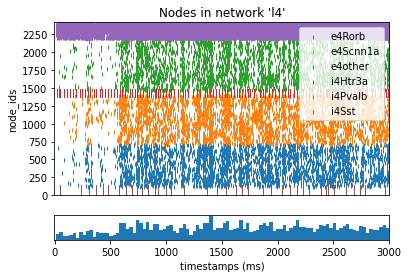

In [7]:
_ = plot_raster(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

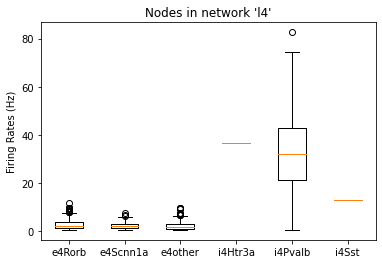

In [8]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

However these results don't show us how well tunned the network is for the given stimuli. "**tuning_angle**” is an optional, user-defined property added to the SONATA files for this model to make model construction easier. Basically, it determines the direction of motion in the visual space that this cell is expected to prefer. Whether the cell actually prefers that direction or not in any given model and simulation is not guaranteed – that depends on how the model is built and conditions of the simulation. But this is a convenient label that can be used throughout model building to wire the network according to the desired specifications and then check whether simulation show the intended trends. 

The function below plots the firing rates of excitatory or inhibitory neurons as a function of their **tuning_angle** property.

In [20]:
def plot_tunning_angle_fr(spikes_path, fr_window=(500.0, 3000.0), convolv_window=10):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0

    net = sonata.File(
        data_files='network/l4_nodes.h5',
        data_type_files='network/l4_node_types.csv'
    )
    nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]

    spikes = SpikeTrains.load(spikes_path)
    spikes_df = spikes.to_dataframe(population='l4')

    fr_df = spikes_df['node_ids'].value_counts().rename_axis('node_id').to_frame('spike_counts').reset_index()
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)
    fr_df['tuning_rounded'] = 0.0

    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        # print(grp_df.index.values)
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if convolv_window and len(fr_avgs['firing_rates']) > convolv_window:
            filter = np.array([1.0] * int(convolv_window)) / float(convolv_window)
            fr_avgs['firing_rates'] = np.convolve(fr_avgs['firing_rates'].values, filter, mode='same')

        ax.plot(fr_avgs['firing_rates'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')

    # plot excitatory cells by layer
    nrows = 2
    fig, axes = plt.subplots(nrows, 1, figsize=(10, 5))
    for r, layer in enumerate(['VisL4']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(nrows):
        if r != (nrows - 1):
            axes[r].set_xticklabels([])

    plt.show()


Now we use the function above to plot the firing rates of neurons as a function of their assigned “tuning_angle” (as blue dots), as well as a running average (as a red line). We can see in the plots below that at this point the model does not show much of tuning to the visual stimulus it receives from the lgn population. The stimulus we apply is a grating drifting in a certain direction – but we can see that no matter what direction the cells are supposedly preferring, their firing rates are more or less the same for all **tuning_angle**s. 

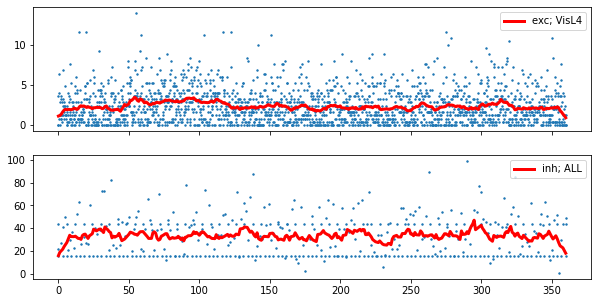

In [21]:
plot_tunning_angle_fr('output_feedforward/spikes.h5')

As we can see there is a slight increase in firing rates around the 90 degree cells that may or may not be significant. The bigger issue is that the cells with just the feedforward inputs are firing at a rate that is slightly higher than we would like. Let us proceed with the fully recurrent model to see if this will fix the issue.

#### Full model

We are now ready to run the simulation with the l4-->l4 current connections added back. The main difference between running a feedforward only simualation and a simulation with recurrent connections is adding back the l4-->l4 connectivity file to our config:

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
        "node_types_file": "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/l4_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/l4_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/bkg_v1_edges.h5",
        "edge_types_file": "$NETWORK_DIR/bkg_v1_edge_types.csv"
      }
    ]
  }
```

However should we run run the simulation as before we will get the following error:
    
<div class="alert alert-block alert-danger">
<b>[ERROR]</b> Unable to calculate synaptic weight for "l4_to_l4" edges, missing "weight_function" attribute value DirectionRule_others function.
</div>

This is because in our L4 --> L4 connections we added special property "**weight_function**", with rules depending on whether the connections are excitatory-to-excitatory (DirectionRule_EE) or otherwise (DirectionRule_others).

In [10]:
edge_types_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ')
edge_types_df.iloc[5:10].style.applymap(lambda *_: 'background-color: yellow', subset=pd.IndexSlice[:, 'weight_function'])

,edge_type_id,target_query,source_query,dynamics_params,syn_weight,delay,weight_sigma,weight_function,model_template
5,105,cell_line=='i4Pvalb',cell_line=='i4Sst',i2i.json,-1.120146,1.500000,50.000000,DirectionRule_others,static_synapse
6,106,cell_line=='i4Sst',cell_line=='e4Rorb',e2i.json,3.388120,1.500000,90.000000,DirectionRule_others,static_synapse
7,107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,5.154132,1.300000,30.000000,DirectionRule_EE,static_synapse
8,108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,13.687266,1.300000,30.000000,DirectionRule_EE,static_synapse
9,109,cell_line=='i4Htr3a',cell_line=='e4Rorb',e2i.json,1.027934,1.500000,90.000000,DirectionRule_others,static_synapse


The **weight_function** is a special directive to indicate to bmtk special user-defined rules for how to recalculate synaptic weights based on the properties of the edges, source and target cells. In this case *DirectionRule_EE* and *DirectionRule_others* are user-defined functions that take as parameters pandas DataFrames for the current set of edge_properties, source-cell properties and target-cell properties; and should return a list of floating point values representing the syn_weights.

To let bmtk know the location of the function we use special python decorators:

```python
from bmtk.simulator.pointnet import synaptic_weight

@synpatic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    ...
    return syn_weights

```

When running the simulation bmtk will see the user defined function and use it recalulate the synaptic weights.

By default bmtk calculates the weights using the SONATA reserved value *syn_weight* times the *nsyns* value. We can try implementing our *DirectionRule*'s using the same method and running the fully recurrent simulation.

In [11]:
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight

@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    return edge_props['syn_weight']*edge_props.nsyns


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    return edge_props['syn_weight']*edge_props.nsyns


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-06-16 11:55:55,562 [INFO] Created log file
2022-06-16 11:55:55,605 [INFO] Batch processing nodes for l4/0.
2022-06-16 11:55:55,694 [INFO] Batch processing nodes for lgn/0.
2022-06-16 11:55:55,702 [INFO] Batch processing nodes for bkg/0.
2022-06-16 11:55:55,805 [INFO] Setting up output directory
2022-06-16 11:55:55,805 [INFO] Building cells.
2022-06-16 11:55:55,884 [INFO] Building recurrent connections
2022-06-16 11:55:56,555 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-16 11:56:08,487 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-16 11:56:08,529 [INFO] Network created.
2022-06-16 11:56:08,555 [INFO] Starting Simulation
2022-06-16 11:56:26,308 [INFO] Simulation finished, finalizing results.
2022-06-16 11:56:33,466 [INFO] Done.


However, when we look at the results, instead of decreasing the firing-rates and improving the tuning-angle curve, it makes things significantly worse. In particularly the recurrent excictatory connections are too strong causing the other cells to fire out-of-control.

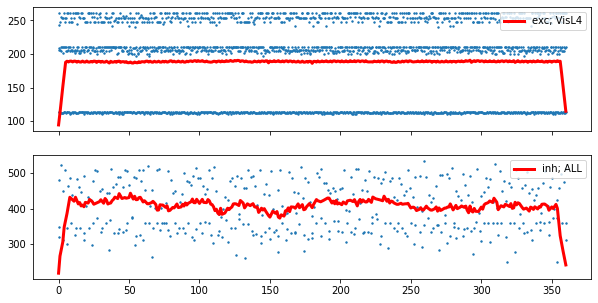

In [12]:
plot_tunning_angle_fr('output/spikes.h5')

But re-implementing the default functionality in our custom user-written function is not ideal. Instead we define our own functions where the adjustment to the synaptic weights is weighted based on the difference between the **tuning_angle** of the source and target cells.

In [13]:
from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight


@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values

    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)
       
    return syn_weight*w_multiplier_180*nsyn


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    x_tar = target_nodes['x'].values
    x_src = source_nodes['x'].values
    z_tar = target_nodes['z'].values
    z_src = source_nodes['z'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values
    
    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)

    delta_x = (x_tar - x_src) * 0.07
    delta_z = (z_tar - z_src) * 0.04

    theta_pref = tar_tuning * (np.pi / 180.)
    xz = delta_x * np.cos(theta_pref) + delta_z * np.sin(theta_pref)
    sigma_phase = 1.0
    phase_scale_ratio = np.exp(-(xz**2 / (2*sigma_phase**2)))

    # To account for the 0.07 vs 0.04 dimensions. This ensures the horizontal neurons are scaled by 5.5/4
    # (from the midpoint of 4 & 7). Also, ensures the vertical is scaled by 5.5/7. This was a basic 
    # linear estimate to get the numbers (y = ax + b).
    theta_tar_scale = abs(abs(abs(180.0 - np.mod(np.abs(tar_tuning), 360.0)) - 90.0) - 90.0)
    phase_scale_ratio = phase_scale_ratio * (5.5 / 4.0 - 11.0 / 1680.0 * theta_tar_scale)

    return syn_weight*w_multiplier_180*phase_scale_ratio*nsyn


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-06-16 11:56:55,275 [INFO] Created log file
2022-06-16 11:56:55,305 [INFO] Batch processing nodes for l4/0.
2022-06-16 11:56:55,379 [INFO] Batch processing nodes for lgn/0.
2022-06-16 11:56:55,388 [INFO] Batch processing nodes for bkg/0.
2022-06-16 11:56:55,493 [INFO] Setting up output directory
2022-06-16 11:56:55,494 [INFO] Building cells.
2022-06-16 11:56:55,577 [INFO] Building recurrent connections
2022-06-16 11:56:56,276 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-16 11:57:08,119 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-16 11:57:08,161 [INFO] Network created.
2022-06-16 11:57:08,189 [INFO] Starting Simulation
2022-06-16 11:57:14,877 [INFO] Simulation finished, finalizing results.
2022-06-16 11:57:15,106 [INFO] Done.


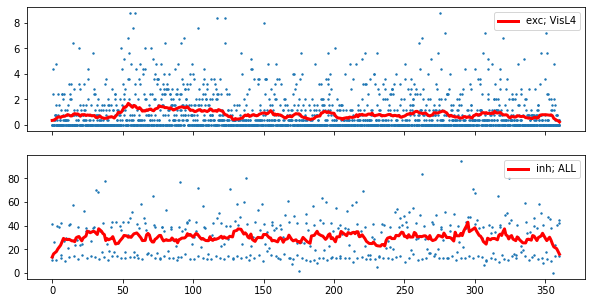

In [14]:
plot_tunning_angle_fr('output/spikes.h5')

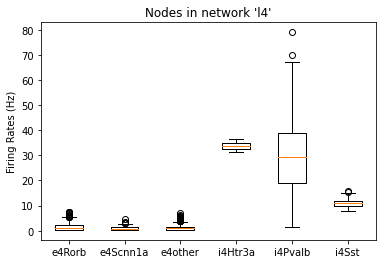

In [15]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

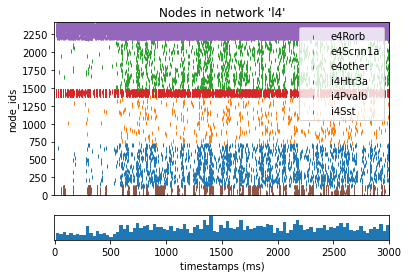

In [16]:
_ = plot_raster(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

The **weight_function** option provides a dynamic way to test and adjust the synaptic weights in ```PointNet``` and ```BioNet``` at simulation time without having to rebuild the network each time - in which for large networks can take a signficant amount of time. It can also be used to fine tune the synaptic-weight parameters using conjugate-gradient methods or grid searches - examples of which are show in the [following Notebook](./6C.%20Parameter%20Tuning.ipynb)

#### Adding Perturbations

A common and useful tool in both in-silico and in-vivo neuroscience is the ability to enhance and/or inhibit different cell types. for example if we want to completely dishibit the i4Pvalb cells we can add a strong negative current clamp to the "inputs" section in the json config

```json
  "inputs": {
    "inh_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {"population": "l4", "cell_line": "i4Pvalb"},
        "amp": -2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-06-16 11:57:40,790 [INFO] Created log file
2022-06-16 11:57:40,832 [INFO] Batch processing nodes for l4/0.
2022-06-16 11:57:40,969 [INFO] Batch processing nodes for lgn/0.
2022-06-16 11:57:40,979 [INFO] Batch processing nodes for bkg/0.
2022-06-16 11:57:41,086 [INFO] Setting up output directory
2022-06-16 11:57:41,087 [INFO] Building cells.
2022-06-16 11:57:41,175 [INFO] Building recurrent connections
2022-06-16 11:57:41,949 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-16 11:57:53,552 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-16 11:57:53,759 [INFO] Network created.
2022-06-16 11:57:53,790 [INFO] Starting Simulation
2022-06-16 11:58:24,686 [INFO] Simulation finished, finalizing results.
2022-06-16 11:58:24,940 [INFO] Done.


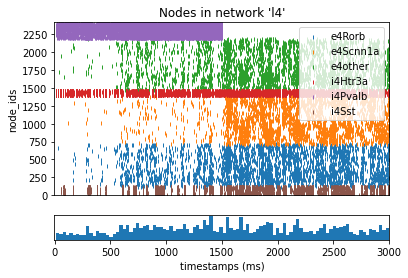

In [17]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.pert_pvalb.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_pvalb.json', group_by='cell_line')

Not only are we able to completely knock out the Parvaralbium cells in Layer 4, we can see and compare the effect this has on the rest of the recurrently-connected network. Similary we can excite the cells with a strong positive current, or even excite/inhibite different cells at different times during the same simulation.

We can also stimulate subsets of cells in the network. Here we just need to change the *node_set* so that it targets only the biophysically detailed "e4Rorb" and "e4Scnn1a" cells, and change the *amp*litude to a large positive value:

```json
  "inputs": {
    "exc_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
          "population": "l4",
          "model_type": "biophysical",
          "cell_line": ["e4Rorb", "e4Scnn1a"],
        },
        "amp": 2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-06-16 11:58:34,596 [INFO] Created log file
2022-06-16 11:58:34,654 [INFO] Batch processing nodes for l4/0.
2022-06-16 11:58:34,733 [INFO] Batch processing nodes for lgn/0.
2022-06-16 11:58:34,742 [INFO] Batch processing nodes for bkg/0.
2022-06-16 11:58:34,854 [INFO] Setting up output directory
2022-06-16 11:58:34,854 [INFO] Building cells.
2022-06-16 11:58:34,946 [INFO] Building recurrent connections
2022-06-16 11:58:35,647 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-16 11:58:47,880 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-16 11:58:48,482 [INFO] Network created.
2022-06-16 11:58:48,511 [INFO] Starting Simulation
2022-06-16 11:59:27,235 [INFO] Simulation finished, finalizing results.
2022-06-16 11:59:29,376 [INFO] Done.


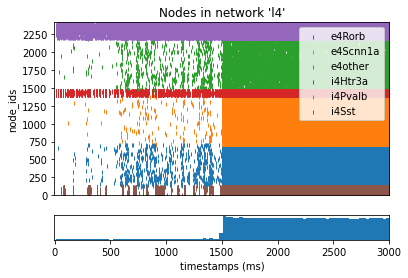

In [18]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_exc.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_exc.json', group_by='cell_line')

We can also run mutltiple perterbations in the same simulation, in serial or in parallel. We just need to add multiple sections in the "inputs":

```json
  "inputs": {
    "current_clamp_1": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "cell_line": "e4Rorb"
      },
      "amp": -2000.000,
      "delay": 500.0,
      "duration": 500.0
    },
    "current_clamp_2": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "cell_line": "e4Rorb"
      },
      "amp": 2000.000,
      "delay": 1500.0,
      "duration": 500.0
    },
    "current_clamp_3": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "ei": "i"
      },
      "amp": -2000.000,
      "delay": 2500.0,
      "duration": 500.0
    }
  },
```

2022-06-16 11:59:54,273 [INFO] Created log file
2022-06-16 11:59:54,308 [INFO] Batch processing nodes for l4/0.
2022-06-16 11:59:54,385 [INFO] Batch processing nodes for lgn/0.
2022-06-16 11:59:54,392 [INFO] Batch processing nodes for bkg/0.
2022-06-16 11:59:54,508 [INFO] Setting up output directory
2022-06-16 11:59:54,508 [INFO] Building cells.
2022-06-16 11:59:54,601 [INFO] Building recurrent connections
2022-06-16 11:59:55,317 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-16 12:00:09,361 [INFO] Build virtual cell stimulations for bkg_spikes
2022-06-16 12:00:10,364 [INFO] Network created.
2022-06-16 12:00:10,406 [INFO] Starting Simulation
2022-06-16 12:00:52,240 [INFO] Simulation finished, finalizing results.
2022-06-16 12:00:52,938 [INFO] Done.


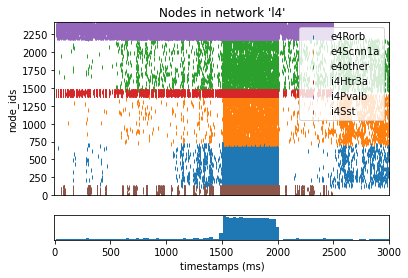

In [19]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_multiple.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_multiple.json', group_by='cell_line')